<a href="https://colab.research.google.com/github/XingxinHE/Python-for-Data-Analysis-Notes/blob/master/10_3_Apply_General_split_apply_combine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


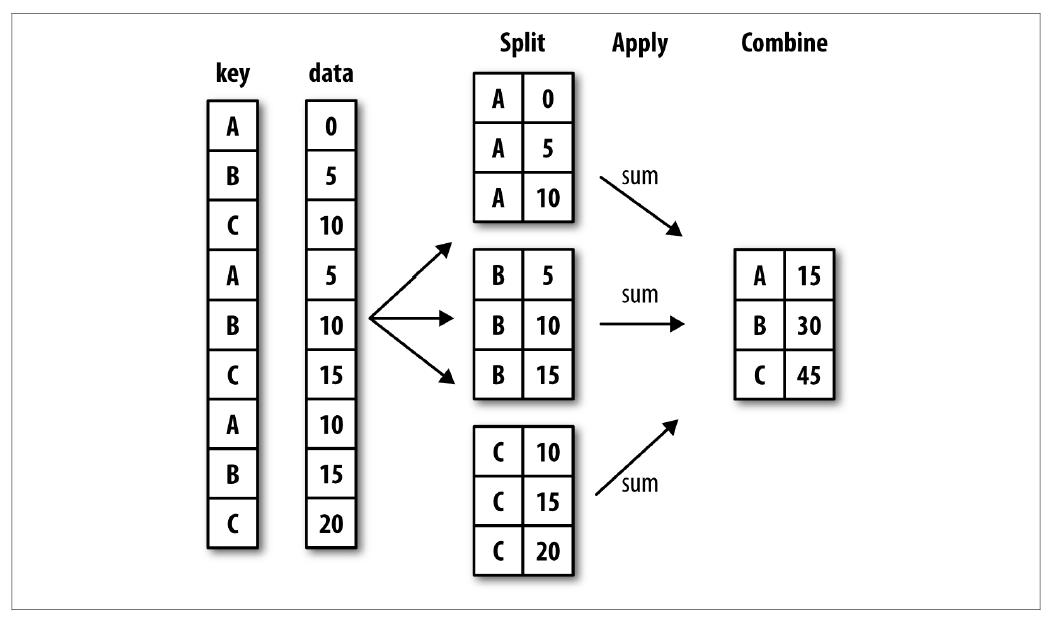

apply 是 groupby工作流的核心

In [2]:
url = 'https://raw.githubusercontent.com/wesm/pydata-book/2nd-edition/examples/tips.csv'
tips = pd.read_csv(url)
tips['tip_pct'] = tips['tip'] / tips['total_bill']

In [3]:
#定义一个function
def top(df, n=5, column='tip_pct'):
  return df.sort_values(by=column)[-n:]

#这个函数是对某个column的值排序（默认是tip_pct，但是可以specify），因为ascending是true，所以后面用的是[-n:]

In [4]:
top(tips, n=6)

,total_bill,tip,smoker,day,time,size,tip_pct
109,14.31,4.00,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Yes,Sun,Dinner,4,0.280535
232,11.61,3.39,No,Sat,Dinner,2,0.291990
67,3.07,1.00,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Yes,Sun,Dinner,2,0.710345


In [5]:
tips.groupby('smoker').apply(top) #可以看到，没有specify的时候，默认tip_pct是从小到大

total_bill   tip smoker   day    time  size   tip_pct
smoker                                                           
No     88        24.71  5.85     No  Thur   Lunch     2  0.236746
       185       20.69  5.00     No   Sun  Dinner     5  0.241663
       51        10.29  2.60     No   Sun  Dinner     2  0.252672
       149        7.51  2.00     No  Thur   Lunch     2  0.266312
       232       11.61  3.39     No   Sat  Dinner     2  0.291990
Yes    109       14.31  4.00    Yes   Sat  Dinner     2  0.279525
       183       23.17  6.50    Yes   Sun  Dinner     4  0.280535
       67         3.07  1.00    Yes   Sat  Dinner     1  0.325733
       178        9.60  4.00    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Yes   Sun  Dinner     2  0.710345

In [6]:
#pd的apply定义参数居然是在function外面！本以为应该是top(n=1,col=xxx)，但这个却是在apply这个括号里面
tips.groupby(['smoker','day']).apply(top, n=1, column='total_bill') 

total_bill    tip smoker   day    time  size   tip_pct
smoker day                                                             
No     Fri  94        22.75   3.25     No   Fri  Dinner     2  0.142857
       Sat  212       48.33   9.00     No   Sat  Dinner     4  0.186220
       Sun  156       48.17   5.00     No   Sun  Dinner     6  0.103799
       Thur 142       41.19   5.00     No  Thur   Lunch     5  0.121389
Yes    Fri  95        40.17   4.73    Yes   Fri  Dinner     4  0.117750
       Sat  170       50.81  10.00    Yes   Sat  Dinner     3  0.196812
       Sun  182       45.35   3.50    Yes   Sun  Dinner     3  0.077178
       Thur 197       43.11   5.00    Yes  Thur   Lunch     4  0.115982

## Suppressing the Group Keys

In [7]:
#把group的键在结果中删除
tips.groupby('smoker', group_keys=False).apply(top)

,total_bill,tip,smoker,day,time,size,tip_pct
88,24.71,5.85,No,Thur,Lunch,2,0.236746
185,20.69,5.00,No,Sun,Dinner,5,0.241663
51,10.29,2.60,No,Sun,Dinner,2,0.252672
149,7.51,2.00,No,Thur,Lunch,2,0.266312
232,11.61,3.39,No,Sat,Dinner,2,0.291990
109,14.31,4.00,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Yes,Sun,Dinner,4,0.280535
67,3.07,1.00,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Yes,Sun,Dinner,2,0.710345


## Quantile and Bucket Analysis

💡这个工作流非常重要！就是把column的数分成几个区间，然后看这个区间的stats，以及对这些区间apply不同的function

In [8]:
frame = pd.DataFrame({'data1': np.random.randn(1000),
            'data2': np.random.randn(1000)})
frame.head()

,data1,data2
0,1.586954,-0.573505
1,-0.130973,-0.314460
2,-1.832199,-0.447627
3,-0.399795,-1.335446
4,-0.526229,1.581859


In [9]:
quartiles = pd.cut(frame.data1, 4)
quartiles

0        (1.475, 2.927]
1      (-1.429, 0.0229]
2      (-2.887, -1.429]
3      (-1.429, 0.0229]
4      (-1.429, 0.0229]
             ...       
995    (-1.429, 0.0229]
996    (-2.887, -1.429]
997    (-1.429, 0.0229]
998     (0.0229, 1.475]
999     (0.0229, 1.475]
Name: data1, Length: 1000, dtype: category
Categories (4, interval[float64]): [(-2.887, -1.429] < (-1.429, 0.0229] < (0.0229, 1.475] <
                                    (1.475, 2.927]]

pd.cut是把值域分成4个区间，然后每个值在每个区间，而这个区间可以pass in groupby里面！

In [10]:
def get_stats(group):
  return {'min':group.min(), 'max':group.max(), 'count':group.count(), 'mean':group.mean()}

In [11]:
grouped = frame.data2.groupby(quartiles)

In [12]:
grouped.apply(get_stats).unstack()

,min,max,count,mean
data1,,,,
"(-2.887, -1.429]",-2.209420,1.683917,75.0,-0.129502
"(-1.429, 0.0229]",-2.948322,2.957216,420.0,0.009490
"(0.0229, 1.475]",-2.641424,2.935594,435.0,0.004820
"(1.475, 2.927]",-3.107267,2.043359,70.0,-0.400370


## Example: Filling Missing Values with Group-Specific Values

fillna用来把df里面的na给处理掉

In [13]:
s = pd.Series(np.random.randn(6))
s[::2] = np.nan
s

0         NaN
1    0.452599
2         NaN
3   -0.415481
4         NaN
5    1.068238
dtype: float64

In [14]:
s.fillna(s.mean()) #fill平均数

0    0.368452
1    0.452599
2    0.368452
3   -0.415481
4    0.368452
5    1.068238
dtype: float64

针对不同的group给不同的fill值

In [15]:
states = ['Ohio', 'New York', 'Vermont', 'Florida', 'Oregon', 'Nevada', 'California', 'Idaho']
group_key = ['East'] * 4 + ['West'] * 4 #前面4个是东部，后面4个是西部
data = pd.Series(np.random.randn(8), index=states)
data

Ohio          0.146836
New York     -0.263537
Vermont      -0.487461
Florida      -1.003001
Oregon        0.184124
Nevada        0.429166
California   -0.286859
Idaho         1.748703
dtype: float64

In [16]:
data[['Vermont', 'Nevada', 'Idaho']] = np.nan
data

Ohio          0.146836
New York     -0.263537
Vermont            NaN
Florida      -1.003001
Oregon        0.184124
Nevada             NaN
California   -0.286859
Idaho              NaN
dtype: float64

In [17]:
#根据东西部而group且得出平均值
data.groupby(group_key).mean()

East   -0.373234
West   -0.051368
dtype: float64

In [18]:
#求均值的lambda function
fill_mean = lambda g: g.fillna(g.mean())

In [19]:
#对根据东西部而group的数据进行fill_mean函数
#为何g.fillna(g.mean())就是根据东西部赋值呢？
#因为前面的groupby在作祟
data.groupby(group_key).apply(fill_mean)

Ohio          0.146836
New York     -0.263537
Vermont      -0.373234
Florida      -1.003001
Oregon        0.184124
Nevada       -0.051368
California   -0.286859
Idaho        -0.051368
dtype: float64

In [20]:
#下面这种字典形式的赋值可能更加直观
fill_values = {'East':0.5, 'West':-1}

#g.name就是上面字典的key
fill_func = lambda g: g.fillna(fill_values[g.name])

In [21]:
data.groupby(group_key).apply(fill_func)

Ohio          0.146836
New York     -0.263537
Vermont       0.500000
Florida      -1.003001
Oregon        0.184124
Nevada       -1.000000
California   -0.286859
Idaho        -1.000000
dtype: float64

## Example: Random Sampling and Permutation

In [22]:
#红心，黑桃，方块，梅花
suits=['H','S','C','D']

#每个花色都有1-10，然后JQK； 后面3个10分别代表JQK的值
card_val = (list(range(1,11)) + [10]*3) *4

#构建牌名
base_names = ['A'] + list(range(2,11)) + ['J','Q','K']

In [25]:
#所有牌
cards = []

#花色和牌名对号
for suit in suits:
  cards.extend(str(num) + suit for num in base_names)

In [26]:
cards

['AH',
 '2H',
 '3H',
 '4H',
 '5H',
 '6H',
 '7H',
 '8H',
 '9H',
 '10H',
 'JH',
 'QH',
 'KH',
 'AS',
 '2S',
 '3S',
 '4S',
 '5S',
 '6S',
 '7S',
 '8S',
 '9S',
 '10S',
 'JS',
 'QS',
 'KS',
 'AC',
 '2C',
 '3C',
 '4C',
 '5C',
 '6C',
 '7C',
 '8C',
 '9C',
 '10C',
 'JC',
 'QC',
 'KC',
 'AD',
 '2D',
 '3D',
 '4D',
 '5D',
 '6D',
 '7D',
 '8D',
 '9D',
 '10D',
 'JD',
 'QD',
 'KD']

In [27]:
#德克deck
deck = pd.Series(card_val, index=cards)

In [28]:
deck[:13] #看看前13张牌

AH      1
2H      2
3H      3
4H      4
5H      5
6H      6
7H      7
8H      8
9H      9
10H    10
JH     10
QH     10
KH     10
dtype: int64

In [29]:
#定义随机抽取（5张）牌的函数
def draw(deck, n=5):
  return deck.sample(n)

In [30]:
#抽牌
draw(deck)

5S      5
5D      5
3H      3
2H      2
10S    10
dtype: int64

假设从每个花色抽2张牌

In [34]:
#花色是牌名的最后一个index
get_suit = lambda card: card[-1]

In [35]:
#这尼玛就很神奇了，groupby还能groupby function？！？
deck.groupby(get_suit).apply(draw, n=2)

C  KC     10
   QC     10
D  6D      6
   QD     10
H  QH     10
   7H      7
S  JS     10
   10S    10
dtype: int64

In [36]:
#若不想hierarchical index
deck.groupby(get_suit, group_keys=False).apply(draw, n=2)

2C     2
5C     5
5D     5
3D     3
KH    10
JH    10
JS    10
5S     5
dtype: int64

## Example: Group Weighted Average and Correlation

对相邻的column或者group进行操作

In [37]:
df = pd.DataFrame({'category': ['a', 'a', 'a', 'a',
          'b', 'b', 'b', 'b'],
          'data': np.random.randn(8),
          'weights': np.random.rand(8)})
df

,category,data,weights
0,a,1.014489,0.422950
1,a,-2.550403,0.977443
2,a,-0.830224,0.035896
3,a,0.114521,0.282243
4,b,-2.448728,0.257890
5,b,0.304474,0.785101
6,b,-1.138392,0.733786
7,b,-0.961138,0.291756


In [38]:
grouped = df.groupby('category')

In [41]:
get_wavg = lambda g: np.average(g['data'], weights=g['weights'])

In [42]:
grouped.apply(get_wavg)

category
a   -1.199439
b   -0.729122
dtype: float64

In [45]:
tips

,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,0.059447
1,10.34,1.66,No,Sun,Dinner,3,0.160542
2,21.01,3.50,No,Sun,Dinner,3,0.166587
3,23.68,3.31,No,Sun,Dinner,2,0.139780
4,24.59,3.61,No,Sun,Dinner,4,0.146808
...,...,...,...,...,...,...,...
239,29.03,5.92,No,Sat,Dinner,3,0.203927
240,27.18,2.00,Yes,Sat,Dinner,2,0.073584
241,22.67,2.00,Yes,Sat,Dinner,2,0.088222
242,17.82,1.75,No,Sat,Dinner,2,0.098204
